# [DRAFT] Solving a Dirichlet problem on a circle.

In [32]:
from tectosaur2.nb_config import setup

setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from tectosaur2 import integrate_term, refine_surfaces, gauss_rule
from tectosaur2.laplace2d import double_layer

In [34]:
nq = 10
quad_rule = gauss_rule(nq)

t = sp.symbols("t")
theta = sp.pi * (t + 1)
circle = refine_surfaces([(t, sp.cos(theta), sp.sin(theta))], quad_rule)
circle.n_pts, circle.n_panels

(320, 32)

For our test solution function, we use $f(x, y) = 2 + x + y$ because the Laplacian is trivially equal to zero, thus satisfying both the underlying PDE and integral equation. 

In [35]:
## This is g
def soln_fnc(x, y):
    return 2 + x + y

bcs = soln_fnc(circle.pts[:, 0], circle.pts[:, 1])
A,report = integrate_term(double_layer, circle.pts, circle, return_report=True)
surf_density = np.linalg.solve(-A[:,0,:,0], bcs)

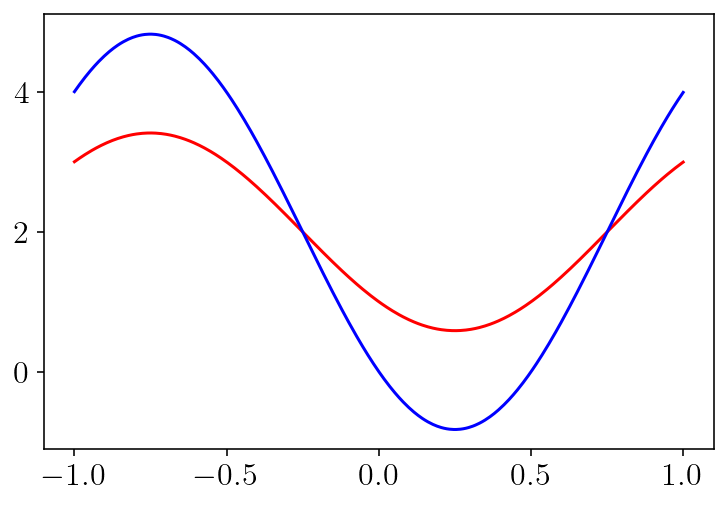

In [36]:
plt.plot(circle.quad_pts, bcs, 'r-')
plt.plot(circle.quad_pts, surf_density, 'b-')
plt.show()

In [37]:
nobs = 200
offset = -0.1
zoomx = [-1.0 + offset, 1.0 - offset]
zoomy = [-1.0 + offset, 1.0 - offset]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs2d = np.array([obsx.flatten(), obsy.flatten()]).T.copy()
obs2d_mask = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 1
obs2d_mask_sq = obs2d_mask.reshape(obsx.shape)
obs2d_mask_away = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 0.9
obs2d_mask_away_sq = obs2d_mask_away.reshape(obsx.shape)
correct = soln_fnc(obsx, obsy)

In [38]:
%%time
interior_disp_mat = integrate_term(double_layer, obs2d, circle, tol=1e-13)
u_soln = -interior_disp_mat[:, 0, :, 0].dot(surf_density).reshape(obsx.shape)

CPU times: user 947 ms, sys: 123 ms, total: 1.07 s
Wall time: 349 ms


/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_4604/2284990632.py:24: RuntimeWarning: divide by zero encountered in log10
  to_plot = np.log10(np.abs(correct - u_soln))


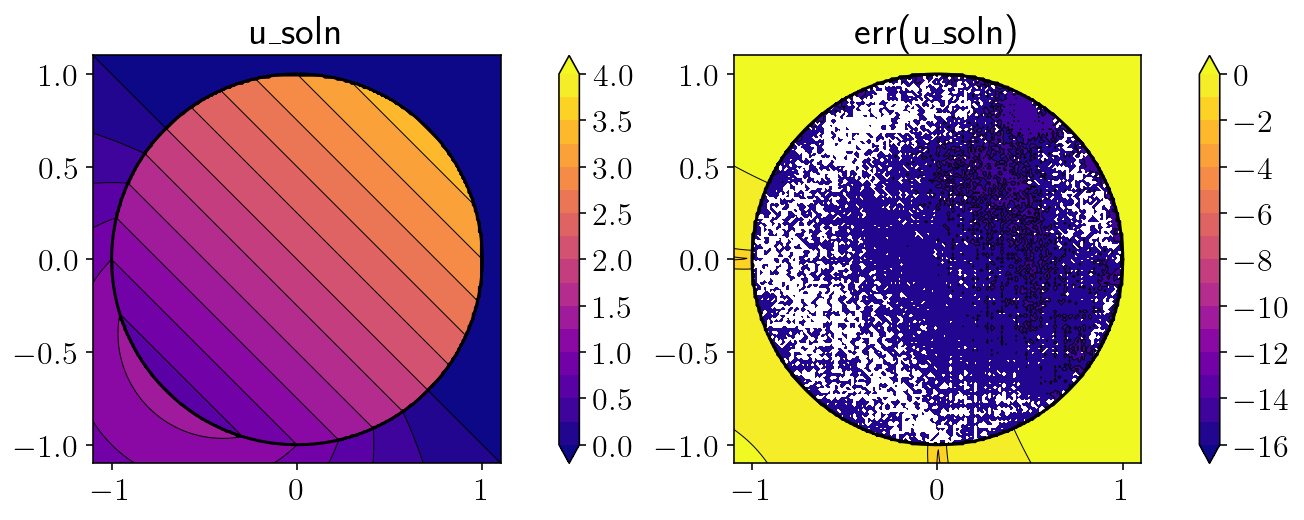

In [39]:
plt.figure(figsize=(9, 3.5), constrained_layout=True)
plt.subplot(1, 2, 1)
levels = np.linspace(0, 4, 17)

cntf = plt.contourf(obsx, obsy, u_soln, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    u_soln,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title(["u\_soln", "u\_soln", "correct"][i])
plt.axis('scaled')

plt.subplot(1, 2, 2)
to_plot = np.log10(np.abs(correct - u_soln))
levels = np.linspace(-16, 0, 17)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle.pts[:, 0], circle.pts[:, 1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title("err(u\_soln)")
plt.axis('scaled')
plt.show()